# Prepare Environment
For cuda version 11.3 and torch version 1.11.\*, install PyTorch Geometric and its dependecies with following commands. For other version, please refer to [PyG official installation instruction](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) to check if your machine is supported and specific version to install.

In [1]:
!pip install --upgrade torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
!python -c "import torch; print(torch.__version__); print(torch.version.cuda);"
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
1.11.0+cu113
11.3
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html


# Prepare the Dataset
## Step1: Read Raw Data from Parquet Files

In [2]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

ds_dir = glob.glob('../input/boosted-top-tau-4/*')
X_jets = []
lables = []

for file_name in tqdm(ds_dir):
    df = pd.read_parquet(file_name)
    X_jets.append(np.array(df['X_jets'].tolist()).astype(np.float32))
    lables.append(df['y'].to_numpy())

100%|██████████| 3/3 [00:51<00:00, 17.30s/it]


The Boosted Top Tau Particle dataset contains X_jets, y, m0, and pt columns, where y represents the label for tau sample and the X_jets column is 125x125 jets image matrices of 8 channels (pt, d0, dz ECAL, HCAL, BPIX1, BPIX2, and BPIX3), more specifically

- (pt, d0, dz) are tracker layers.
- ECAL and HCAL are electromagnetic and hadronic calorimeter deposits respectively.
- BPIX are the pixel layers which are integer values representing the number of collisions occurring in the pixel layers.
    
The tracker layers, ECAL and HCAL channels are already scaled, so there's no need to normalize them.

In [3]:
df.head()

,X_jets,y,m0,pt
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,181.342728,491.635803
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,159.301620,757.597900
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,93.660439,682.969482
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,202.057114,765.743225
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,157.177841,505.105835


Next step, first convert list of X_jets to numpy arrays. Then, reshape the dataset to channel last format. The shape of numpy array should be transformed from (n_samples, 125000) to (n_samples, 125x125, 8).
    
The reason why I didn't reshape samples to (n_samples, 125, 125, 8) is the idea of representing the data with unordered graph, in which case, given the unordered nature of nodes, the pixels of jets image should be flattened from (125, 125) to (125x125).

In [4]:
X_jets = np.array(X_jets).reshape((-1,125000))
lables = np.array(lables).reshape((-1,1))
X_data = X_jets.reshape((-1,125*125,8))
print('Before:', X_jets[0].shape)
print('After:', X_data[0].shape)

Before: (125000,)
After: (15625, 8)


## Step2: Represent Jets Image with Graph
### Node
The pixel along X_jets channels. To best consentrate informations in jets image with graph, the blank pixels along all channels in jets image are disgarded. For example, if the pixels with 8 channels has value (0,0,0,0,0,0,0,0) is disposed but (0,0,0,0,1,0,0,0) is preserved. The choice of channels used in node feature leads to two ways of representing nodes:
* Full channels with tracker layers, ECAL, HCAL and BPIX layers (8 features).
* Channels with tracker layers, ECAL and HCAL (5 features).

In [5]:
# disgard blank pixels
non_black_pixels_mask = np.any(X_data != 0., axis=-1)

# uncomment this line below if represents nodes with first 5 channels
# X_data = X_data[:,:,:5]

node_list = []
for i, x in enumerate(X_data):
    node_list.append(x[non_black_pixels_mask[i]])

# due to RAM limit, clear cache after arrays used
del X_jets, X_data, non_black_pixels_mask

Plot nodes number distribution.

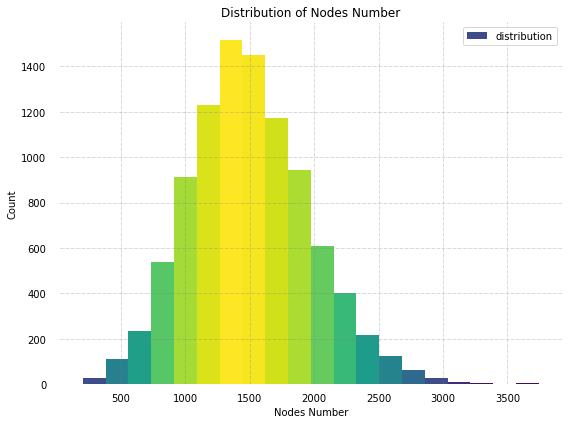

In [6]:
len_list = []
for array in node_list:
    len_list.append(len(array))
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Creating dataset
N_points = len(len_list)
n_bins = 20
 
# Creating distribution
legend = ['distribution']
 
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(8, 6),
                        tight_layout = True)
  
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)
    
# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 5)
axs.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
axs.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
 
# Creating histogram
N, bins, patches = axs.hist(len_list, bins = n_bins)
 
# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())
 
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
# Adding extra features   
plt.xlabel("Nodes Number")
plt.ylabel("Count")
plt.legend(legend)
plt.title('Distribution of Nodes Number')
 
# Show plot
plt.show()

### Edges
Because the physical meaning of edges in high-energy particles is not clear as that in Social networks or Molecular Biology, there are many ways in defining edges and connectivity.
    
One common practice is to determine the graph as a fully-connected graph. However, according to the distribution of nodes number plotted above, it will add too much computational complexity and memory cost, thus, representing the jets image as fully-connected unordered graph is not a wise choice.
    
The edges(connectivity of nodes) used here can be catergoried in two ways:
* **Static Graph**
    - Defined by K Nearest Neighbors.
    - Defined by Radius Neighbors.
* **Dynamic Graph**
    - The connectivity of nodes is not established when nodes data fed into model. In each round of message passing, the connectivity is calculated with the latest nodes value and defined by k nearest neighbors. A typical way is Dynamic Edge Convolution.

*The coding cells of each methods below can be integrated into the data preprocess pipeline and work with different models.* 

In [10]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

#### Static Graph 1:K Nearest Neighbors Graph
Neighbors are points at top k nearest distance. k experimented here are 10, 15, 25. The distance is calculated with Minkowski metric. Sklearn.kneighbors_graph returns connectivity matrix with ones and zeros. This matrix is sparse, to align with PyG graph data format and save memory, convert it to COO format.

In [8]:
from sklearn.neighbors import kneighbors_graph
dataset = []
for i,nodes in enumerate(tqdm(node_list)):
    edges = kneighbors_graph(nodes, 10, mode='connectivity', include_self=True)
    c = edges.tocoo()
    edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
    edge_weight = torch.from_numpy(c.data.reshape(-1,1))
    y = lables[i]
    dataset.append(Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight, y=torch.from_numpy(y).long()))

100%|██████████| 9600/9600 [03:00<00:00, 53.26it/s]


#### Static Graph 2: Radius Neighbors Graph
Neighbors are points at a distance lower than radius. Radius experimented here are 5e-3, 1e-3, 1e-4. The distance is calculated with Minkowski metric. Sklearn.radius_neighbors_graph returns connectivity matrix with ones and zeros. This matrix is sparse, to align with PyG graph data format and save memory, convert it to COO format.

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
dataset = []
for i,nodes in enumerate(tqdm(node_list)):
    edges = radius_neighbors_graph(nodes, 1e-3, mode='connectivity', include_self=True)
    c = edges.tocoo()
    edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
    edge_weight = torch.from_numpy(c.data.reshape(-1,1))
    y = lables[i]
    dataset.append(Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight, y=torch.from_numpy(y).long()))

#### Dynamic Graph
Since the connectivity is not created in the initial state, adding nodes information to PyG graph dataset is enough.

In [ ]:
dataset = []
for i,nodes in enumerate(tqdm(node_list)):
    dataset.append(Data(x=torch.from_numpy(nodes), y=labels[i]))

## Step3: Split dataset and Create Dataloader

In [11]:
rand_seed = 42
X_train, X_test = train_test_split(dataset, test_size=0.1, random_state = rand_seed)
X_train, X_val = train_test_split(X_train, test_size=0.1, random_state = rand_seed)

train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

# quick check for first batch in test loader
batch = next(iter(test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(x=[51994, 8], edge_index=[2, 519940], edge_attr=[519940, 1], y=[32], batch=[51994], ptr=[33])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
